# time comparision before and after use purning

# size comparision

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN Model (using 1D convolutions)
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is assumed to be of shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Function to print model size (total parameters and nonzero parameters)
def print_model_size(model, label=""):
    total_params = sum(p.numel() for p in model.parameters())
    nonzero_params = sum(torch.count_nonzero(p).item() for p in model.parameters())
    print(f"{label} Model: Total parameters = {total_params}, Nonzero parameters = {nonzero_params}")

# Pruning function: zeros out duplicate filters based on cosine similarity.
def prune_similar_filters(model, threshold=0.99):
    """
    For each Conv1d layer in the model, compute cosine similarity between filters.
    Filters with cosine similarity > threshold are considered duplicates and are zeroed out.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            weight = module.weight.data  # shape: (out_channels, in_channels, kernel_size)
            out_channels = weight.shape[0]
            # Flatten each filter to a vector.
            filters = weight.view(out_channels, -1)
            keep_indices = []
            pruned_indices = set()
            for i in range(out_channels):
                if i in pruned_indices:
                    continue
                keep_indices.append(i)
                for j in range(i + 1, out_channels):
                    if j in pruned_indices:
                        continue
                    # Compute cosine similarity between filter i and j.
                    cos_sim = F.cosine_similarity(filters[i].unsqueeze(0), filters[j].unsqueeze(0)).item()
                    if cos_sim > threshold:
                        pruned_indices.add(j)
            # Zero out the duplicate filters.
            for j in pruned_indices:
                module.weight.data[j] = 0
                if module.bias is not None:
                    module.bias.data[j] = 0
            print(f"Layer {name}: kept {len(keep_indices)} out of {out_channels} filters (pruned {len(pruned_indices)})")
    return model

# ---------------------
# Example usage below:
# ---------------------

# Define input parameters for the model.
input_dim = 1024   # Adjust this as needed.
num_classes = 81   # Example number of classes.

# Create a model instance.
model = CNNModel(input_dim=input_dim, num_classes=num_classes)

# Print model size before pruning.
print_model_size(model, label="Before Pruning")

# Set the pruning threshold (can be adjusted by the user).
prune_threshold = 0.3

# Apply pruning.
pruned_model = prune_similar_filters(model, threshold=prune_threshold)

# Print model size after pruning.
print_model_size(pruned_model, label="After Pruning")


Before Pruning Model: Total parameters = 17134033, Nonzero parameters = 17133805
Layer model.0: kept 8 out of 32 filters (pruned 24)
Layer model.4: kept 64 out of 64 filters (pruned 0)
Layer model.8: kept 128 out of 128 filters (pruned 0)
After Pruning Model: Total parameters = 17134033, Nonzero parameters = 17133613


# time without purning


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 12.8212 | Test Acc: 6.17% | Time: 1.65 sec
Epoch 2/100 | Loss: 3.1504 | Test Acc: 14.81% | Time: 1.54 sec
Epoch 3/100 | Loss: 1.8745 | Test Acc: 41.98% | Time: 1.53 sec
Epoch 4/100 | Loss: 1.0766 | Test Acc: 53.09% | Time: 1.56 sec
Epoch 5/100 | Loss: 0.5981 | Test Acc: 72.84% | Time: 1.54 sec
Epoch 6/100 | Loss: 0.3394 | Test Acc: 74.07% | Time: 1.54 sec
Epoch 7/100 | Loss: 0.2684 | Test Acc: 82.72% | Time: 1.54 sec
Epoch 8/100 | Loss: 0.1692 | Test Acc: 72.84% | Time: 1.54 sec
Epoch 9/100 | Loss: 0.1894 | Test Acc: 83.95% | Time: 1.60 sec
Epoch 10/100 | Loss: 0.1505 | Test Acc: 74.07% | Time: 1.56 sec
Epoch 11/100 | Loss: 0.1058 | Test Acc: 87.65% | Time: 1.52 sec
Epoch 12/100 | Loss: 0.1224 | Test Acc: 81.48% | Time: 1.52 sec
Epoch 13/100 | Loss: 0.0649 | Test Acc: 81.48% | Time: 1.51 sec

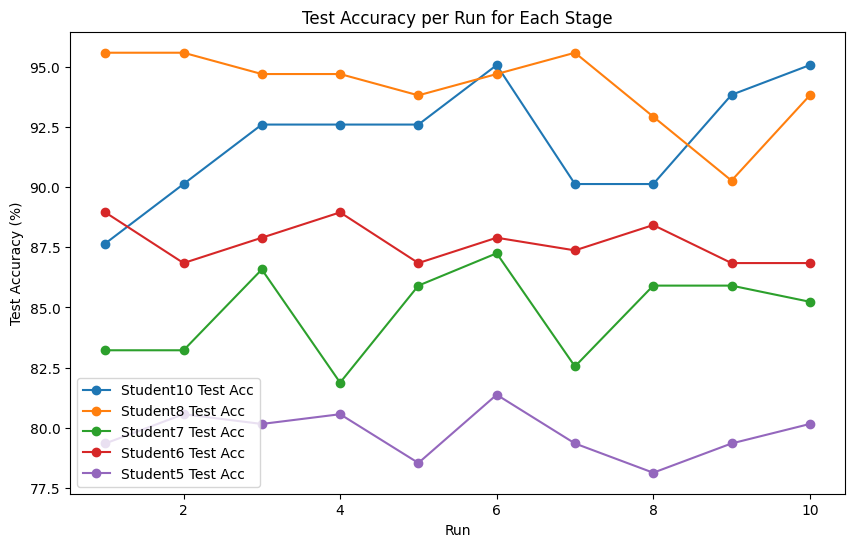

Student10: 91.98%
Student8: 94.16%
Student7: 84.77%
Student6: 87.68%
Student5: 79.76%


In [5]:
import os
import math
import random
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    # Each line is of the form: ">label<TAB>vec0 vec1 ..."
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return vector as float tensor and label as long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x has shape (batch_size, input_dim); add channel dimension.
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]  # [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # [B, num_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Utility: Print Model Size
##########################################
def print_model_size(model, label=""):
    total_params = sum(p.numel() for p in model.parameters())
    nonzero_params = sum(torch.count_nonzero(p).item() for p in model.parameters())
    print(f"{label} Model Size: Total parameters = {total_params}, Nonzero parameters = {nonzero_params}")

##########################################
# Main multi-stage training pipeline
##########################################
# First, load the raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We will store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# To hold teacher models for distillation between stages.
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# A dictionary to store best average accuracy for each stage.
stage_avg_acc = {}

# Stages and corresponding minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    # Filter data based on min_count.
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling to training data.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Get labels and vectors.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create a label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders.
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    # For multi-run experiments.
    run_accs = []
    stage_start_time = time.time()  # Start timer for the stage
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        run_start_time = time.time()  # Start timer for this run
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()  # Start timer for the epoch
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                # For others, combine with distillation loss.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            # Evaluation on test set.
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_acc = 100.0 * correct / total
            
            epoch_duration = time.time() - epoch_start_time  # Calculate epoch duration
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state.
        model.load_state_dict(best_state)
        # Freeze model parameters.
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        run_duration = time.time() - run_start_time  # Calculate duration for the run
        print(f"Run {run+1} Best Test Accuracy: {best_acc:.2f}% | Run Duration: {run_duration:.2f} sec")
        run_accs.append(best_acc)
    
    stage_duration = time.time() - stage_start_time  # Calculate stage duration
    avg_stage_acc = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage_acc
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage_acc:.2f}% ***")
    print(f"Stage {stage_name} took {stage_duration:.2f} seconds.\n")
    
    # Print model size of the current (best) model for this stage.
    print_model_size(model, label=f"{stage_name} model size BEFORE teacher assignment")
    
    # Set teacher for next stage (if any).
    teacher_model = model
    teacher_label2idx = student_label2idx
    
    # Print teacher model size (should be same as current model).
    print_model_size(teacher_model, label=f"{stage_name} teacher model size")

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, _ in stages:
    plt.plot(range(1, num_runs+1), stage_test_accs[stage_name], marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

# Print average accuracies per stage.
for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# for training, reduced training cost

# FP16 quantization, 83.08

In [6]:
import os
import math
import random
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  
        self.labels = labels  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Utility: Print Model Size (Memory Footprint)
##########################################
def print_model_size(model, label=""):
    total_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"{label} Model Size: Total parameters = {total_params}, Memory = {total_bytes/1e6:.2f} MB")

##########################################
# Main multi-stage training pipeline
##########################################
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# Store per-stage test accuracies for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Initialize teacher variables.
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy for each stage.
stage_avg_acc = {}

# Define stages: (stage_name, min_count)
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    stage_start_time = time.time()
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        run_start_time = time.time()
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    # Use the teacher model in half precision.
                    with torch.no_grad():
                        # Convert input to half before passing to teacher.
                        teacher_outputs = teacher_model(data.half()).float()
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_acc = 100.0 * correct / total
            epoch_duration = time.time() - epoch_start_time
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        run_duration = time.time() - run_start_time
        print(f"Run {run+1} Best Test Accuracy: {best_acc:.2f}% | Run Duration: {run_duration:.2f} sec")
        run_accs.append(best_acc)
    
    stage_duration = time.time() - stage_start_time
    avg_stage_acc = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage_acc
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage_acc:.2f}% ***")
    print(f"Stage {stage_name} took {stage_duration:.2f} seconds.\n")
    
    # Print the model size BEFORE quantization for this stage.
    print_model_size(model, label=f"{stage_name} model size BEFORE quantization")
    
    # Now, convert the best model (teacher) to half precision for quantization.
    teacher_model = model.half()
    teacher_label2idx = student_label2idx
    
    # Print the teacher model size AFTER quantization.
    print_model_size(teacher_model, label=f"{stage_name} teacher model size AFTER quantization")

##########################################
# Final Inference Time Measurement
##########################################
orig_inference_time = measure_inference_time(teacher_model, test_loader)
print(f"Final teacher model inference time: {orig_inference_time:.4f} seconds.")

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, _ in stages:
    plt.plot(range(1, num_runs+1), stage_test_accs[stage_name], marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")



########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 9.7564 | Test Acc: 8.64% | Time: 1.73 sec
Epoch 2/100 | Loss: 3.1271 | Test Acc: 25.93% | Time: 1.48 sec
Epoch 3/100 | Loss: 1.8218 | Test Acc: 41.98% | Time: 1.49 sec
Epoch 4/100 | Loss: 0.8466 | Test Acc: 74.07% | Time: 1.49 sec
Epoch 5/100 | Loss: 0.4473 | Test Acc: 79.01% | Time: 1.47 sec
Epoch 6/100 | Loss: 0.3187 | Test Acc: 80.25% | Time: 1.45 sec
Epoch 7/100 | Loss: 0.2139 | Test Acc: 82.72% | Time: 1.44 sec
Epoch 8/100 | Loss: 0.2242 | Test Acc: 85.19% | Time: 1.45 sec
Epoch 9/100 | Loss: 0.1632 | Test Acc: 79.01% | Time: 1.45 sec
Epoch 10/100 | Loss: 0.1380 | Test Acc: 87.65% | Time: 1.45 sec
Epoch 11/100 | Loss: 0.1386 | Test Acc: 88.89% | Time: 1.45 sec
Epoch 12/100 | Loss: 0.1431 | Test Acc: 75.31% | Time: 1.46 sec
Epoch 13/100 | Loss: 0.1033 | Test Acc: 85.19% | Time: 1.46 sec


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

# with delta acc

In [ ]:
import os
import math
import random
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  
        self.labels = labels  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Utility: Print Model Size (Memory Footprint)
##########################################
def print_model_size(model, label=""):
    total_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"{label} Model Size: Total parameters = {total_params}, Memory = {total_bytes/1e6:.2f} MB")

##########################################
# (Optional) Utility: Measure Inference Time
##########################################
def measure_inference_time(model, loader, num_batches=10):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            if i >= num_batches:
                break
            data = data.to(device)
            _ = model(data)
    return time.time() - start_time

##########################################
# Main multi-stage training pipeline
##########################################
raw_data_all = parse_kmer_vector_file(kmer_vector_file)
# Compute global label counts for delta accuracy evaluation.
global_label_counts = Counter([label for label, _ in raw_data_all])

# Store per-stage test accuracies for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}
# Also store delta accuracies per stage.
stage_delta_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Initialize teacher variables.
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy for each stage.
stage_avg_acc = {}

# Define stages: (stage_name, min_count)
# For partitioning, we also keep track of the previous threshold.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]
previous_min_count = None

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    run_delta_accs = []
    stage_start_time = time.time()
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        run_start_time = time.time()
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data.half()).float()
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_acc = 100.0 * correct / total
            epoch_duration = time.time() - epoch_start_time
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        run_duration = time.time() - run_start_time
        print(f"Run {run+1} Best Test Accuracy: {best_acc:.2f}% | Run Duration: {run_duration:.2f} sec")
        run_accs.append(best_acc)
        
        # --- Delta Accuracy Evaluation ---
        all_preds = []
        all_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_trues.extend(labels.cpu().numpy())
        true_labels = label_encoder.inverse_transform(all_trues)
        pred_labels = label_encoder.inverse_transform(all_preds)
        # Select test samples with global count exactly equal to current min_count.
        delta_indices = [i for i, lab in enumerate(true_labels) if global_label_counts[lab] == min_count]
        if delta_indices:
            correct_delta = sum(pred_labels[i] == true_labels[i] for i in delta_indices)
            delta_acc = 100.0 * correct_delta / len(delta_indices)
            print(f"Run {run+1} Delta Accuracy (labels with count == {min_count}): {delta_acc:.2f}% over {len(delta_indices)} samples")
        else:
            delta_acc = 0.0
            print(f"Run {run+1} Delta Accuracy (labels with count == {min_count}): No samples available.")
        run_delta_accs.append(delta_acc)
        
        # --- Partition Accuracy (for stages below the highest) ---
        if previous_min_count is not None:
            # Compute cumulative indices: samples with count >= current min_count.
            indices_cum = [i for i, lab in enumerate(true_labels) if global_label_counts[lab] >= min_count]
            # Group 1: samples that were already in the previous higher-frequency group.
            indices_prev = [i for i in indices_cum if global_label_counts[true_labels[i]] >= previous_min_count]
            # Group 2: samples newly added (with count exactly equal to current min_count).
            indices_delta_partition = [i for i in indices_cum if global_label_counts[true_labels[i]] == min_count]
            if indices_cum:
                cum_acc = 100.0 * sum(pred_labels[i] == true_labels[i] for i in indices_cum) / len(indices_cum)
                prev_acc = 100.0 * sum(pred_labels[i] == true_labels[i] for i in indices_prev) / len(indices_prev) if indices_prev else 0.0
                delta_acc_partition = 100.0 * sum(pred_labels[i] == true_labels[i] for i in indices_delta_partition) / len(indices_delta_partition) if indices_delta_partition else 0.0
                print(f"Partition (for {stage_name}): Cumulative (>= {min_count}) = {cum_acc:.2f}% over {len(indices_cum)} samples, "
                      f"Group (>= {previous_min_count}) = {prev_acc:.2f}% over {len(indices_prev)} samples, "
                      f"Delta (== {min_count}) = {delta_acc_partition:.2f}% over {len(indices_delta_partition)} samples")
        # End run loop.
    
    stage_duration = time.time() - stage_start_time
    avg_stage_acc = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage_acc
    stage_test_accs[stage_name] = run_accs
    stage_delta_accs[stage_name] = run_delta_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage_acc:.2f}% ***")
    avg_delta = sum(run_delta_accs) / len(run_delta_accs) if run_delta_accs else 0.0
    print(f"*** Average {stage_name} Delta Accuracy over {num_runs} runs: {avg_delta:.2f}% ***")
    print(f"Stage {stage_name} took {stage_duration:.2f} seconds.\n")
    
    # Print model size BEFORE quantization.
    print_model_size(model, label=f"{stage_name} model size BEFORE quantization")
    
    # Convert the best model (teacher) to half precision for quantization.
    teacher_model = model.half()
    teacher_label2idx = student_label2idx
    
    # Print teacher model size AFTER quantization.
    print_model_size(teacher_model, label=f"{stage_name} teacher model size AFTER quantization")
    
    # Update previous threshold for partitioning in the next stage.
    previous_min_count = min_count

##########################################
# Final Inference Time Measurement
##########################################
orig_inference_time = measure_inference_time(teacher_model, test_loader)
print(f"Final teacher model inference time: {orig_inference_time:.4f} seconds.")

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, _ in stages:
    plt.plot(range(1, num_runs+1), stage_test_accs[stage_name], marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for stage_name, _ in stages:
    plt.plot(range(1, num_runs+1), stage_delta_accs[stage_name], marker='o', label=f"{stage_name} Delta Acc")
plt.xlabel("Run")
plt.ylabel("Delta Accuracy (%)")
plt.title("Delta Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")



########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 8.2356 | Test Acc: 14.81% | Time: 1.80 sec
Epoch 2/100 | Loss: 2.5524 | Test Acc: 30.86% | Time: 1.61 sec
Epoch 3/100 | Loss: 1.3543 | Test Acc: 56.79% | Time: 1.62 sec
Epoch 4/100 | Loss: 0.6952 | Test Acc: 66.67% | Time: 1.60 sec
Epoch 5/100 | Loss: 0.3713 | Test Acc: 72.84% | Time: 1.60 sec
Epoch 6/100 | Loss: 0.3007 | Test Acc: 79.01% | Time: 1.60 sec
Epoch 7/100 | Loss: 0.2518 | Test Acc: 70.37% | Time: 1.58 sec
Epoch 8/100 | Loss: 0.2353 | Test Acc: 74.07% | Time: 1.58 sec
Epoch 9/100 | Loss: 0.1537 | Test Acc: 76.54% | Time: 1.57 sec
Epoch 10/100 | Loss: 0.1431 | Test Acc: 74.07% | Time: 1.59 sec
Epoch 11/100 | Loss: 0.1534 | Test Acc: 87.65% | Time: 1.59 sec
Epoch 12/100 | Loss: 0.0757 | Test Acc: 77.78% | Time: 1.59 sec
Epoch 13/100 | Loss: 0.1174 | Test Acc: 83.95% | Time: 1.59 sec

# run 2

In [ ]:
import os
import math
import random
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  
        self.labels = labels  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Utility: Print Model Size (Memory Footprint)
##########################################
def print_model_size(model, label=""):
    total_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"{label} Model Size: Total parameters = {total_params}, Memory = {total_bytes/1e6:.2f} MB")

##########################################
# Main multi-stage training pipeline
##########################################
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# Store per-stage test accuracies for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# Initialize teacher variables.
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation.
temperature = 4.5
alpha = 0.5

# Dictionary to store best average accuracy for each stage.
stage_avg_acc = {}

# Define stages: (stage_name, min_count)
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    run_accs = []
    stage_start_time = time.time()
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        run_start_time = time.time()
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    # Use the teacher model in half precision.
                    with torch.no_grad():
                        # Convert input to half before passing to teacher.
                        teacher_outputs = teacher_model(data.half()).float()
                    ce_loss = criterion(outputs, labels)
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_acc = 100.0 * correct / total
            epoch_duration = time.time() - epoch_start_time
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}% | Time: {epoch_duration:.2f} sec")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        model.load_state_dict(best_state)
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        run_duration = time.time() - run_start_time
        print(f"Run {run+1} Best Test Accuracy: {best_acc:.2f}% | Run Duration: {run_duration:.2f} sec")
        run_accs.append(best_acc)
    
    stage_duration = time.time() - stage_start_time
    avg_stage_acc = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage_acc
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage_acc:.2f}% ***")
    print(f"Stage {stage_name} took {stage_duration:.2f} seconds.\n")
    
    # Print the model size BEFORE quantization for this stage.
    print_model_size(model, label=f"{stage_name} model size BEFORE quantization")
    
    # Now, convert the best model (teacher) to half precision for quantization.
    teacher_model = model.half()
    teacher_label2idx = student_label2idx
    
    # Print the teacher model size AFTER quantization.
    print_model_size(teacher_model, label=f"{stage_name} teacher model size AFTER quantization")

##########################################
# Final Inference Time Measurement
##########################################
orig_inference_time = measure_inference_time(teacher_model, test_loader)
print(f"Final teacher model inference time: {orig_inference_time:.4f} seconds.")

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name, _ in stages:
    plt.plot(range(1, num_runs+1), stage_test_accs[stage_name], marker='o', label=f"{stage_name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")
